In [1]:
import pandas as pd
import numpy as np

In [2]:
current_facilities = pd.read_csv("../data/ermera_full/current_facs.csv")
current_facilities["is_built"] = 1
current_facilities = current_facilities.drop(columns=["Hosp_Name"])
current_facilities.columns = ["Pop_Lat", "Pop_Lon", "Population", "Grid_Lat", "Grid_Lon", "Distance_KM", "is_built"]

In [3]:
data_potential = pd.read_csv("../data/ermera_full/grid.csv")
data_potential["is_built"] = 0

In [4]:
data = pd.concat([data_potential, current_facilities], ignore_index=True)

In [5]:
#populations = data_potential[["Pop_Lat", "Pop_Lon", "Population"]].drop_duplicates().reset_index().drop(columns=["index"])
#populations_covered = current_facilities[["Pop_Lat", "Pop_Lon", "Population"]].drop_duplicates().reset_index().drop(columns=["index"])
populations = data[["Pop_Lat", "Pop_Lon", "Population"]].drop_duplicates().reset_index().drop(columns=["index"])

In [6]:
#facilities = data_potential[["Grid_Lat", "Grid_Lon", "is_built"]].drop_duplicates().reset_index().drop(columns=["index"])
#facilities_built = current_facilities[["Grid_Lat", "Grid_Lon", "is_built"]].drop_duplicates().reset_index().drop(columns=["index"])
facilities = data[["Grid_Lat", "Grid_Lon", "is_built"]].drop_duplicates().reset_index().drop(columns=["index"])

In [7]:
distances = pd.DataFrame(
    columns=facilities.index.astype(int),
    index=populations.index.astype(int),
    data=np.nan
)

In [8]:
for i, population in populations.iterrows():
    for j, facility in facilities.iterrows():
        matching_row = data[
            (data["Pop_Lat"] == population["Pop_Lat"]) &
            (data["Pop_Lon"] == population["Pop_Lon"]) &
            (data["Grid_Lat"] == facility["Grid_Lat"]) &
            (data["Grid_Lon"] == facility["Grid_Lon"])
        ]

        if not matching_row.empty:
            distances.at[i,j] = matching_row.iloc[0]["Distance_KM"]

In [9]:
distances.replace(np.nan, 1000, inplace=True)

In [10]:
populations.to_csv("../data/ermera_full/processed/populations.csv")
facilities.to_csv("../data/ermera_full/processed/facilities.csv")
distances.to_csv("../data/ermera_full/processed/distances.csv")

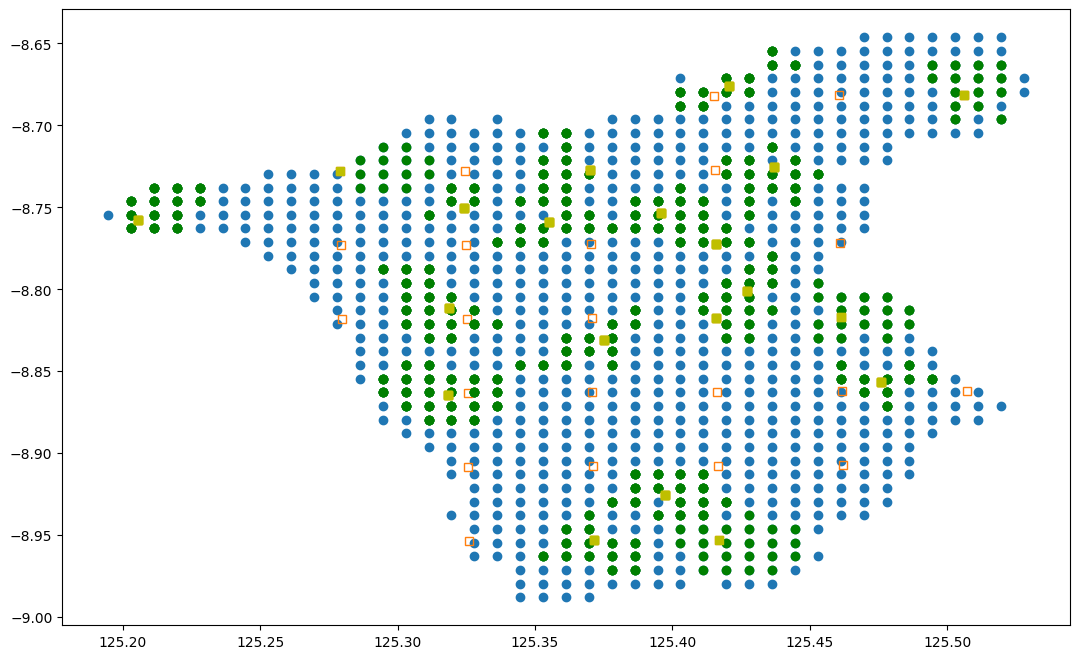

In [38]:
import pandas as pd
import numpy as np
from dynamic_models.single_step import single_step_area
from dynamic_models.visuializer import show_facility_location

#data constants
distances = pd.read_csv("../data/ermera_full/processed/distances.csv").drop(columns=["Unnamed: 0"])
homes = populations
locations = facilities
periods_df = pd.DataFrame([1,2,3,4])
periods = periods_df[0]
per_period = 2
max_distance = 3
open_facilities = facilities["is_built"]
vpop = homes["Population"]


Z, X, building = single_step_area(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)

xC = homes['Pop_Lon']
yC = homes['Pop_Lat']
xF = locations['Grid_Lon']
yF = locations['Grid_Lat']

show_facility_location(xC, yC, xF, yF, X=X, Z=Z, homes=homes, locations=locations, periods=periods)

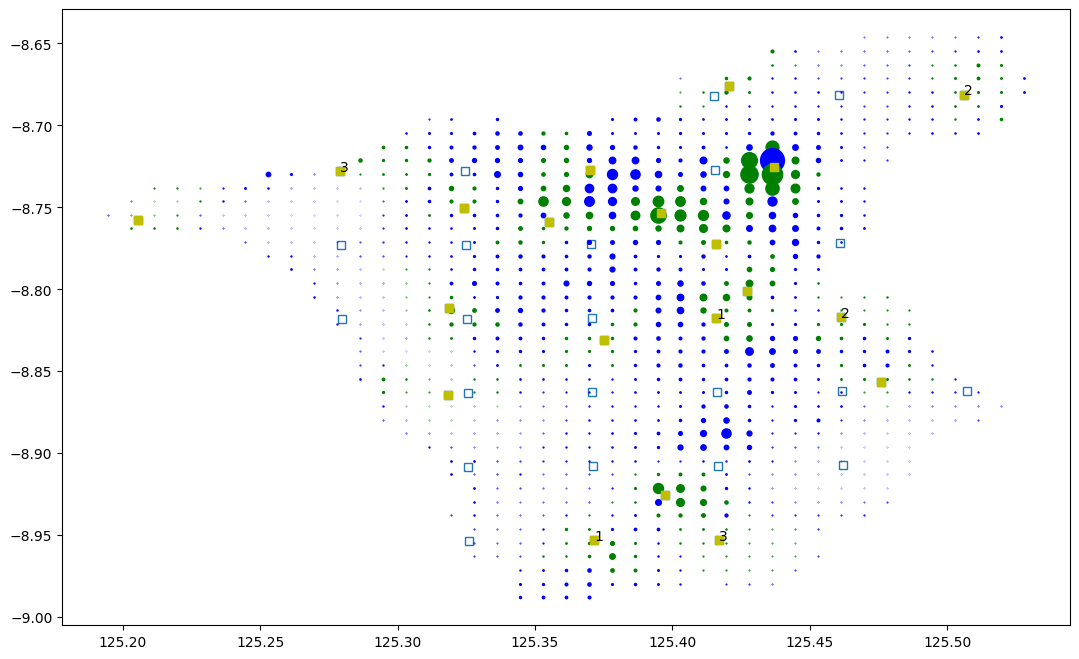

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Optional

def show_facility_location(xC: List[float], 
                         yC: List[float], 
                         xF: List[float], 
                         yF: List[float], 
                         X: List[float], 
                         Z: List[float], 
                         periods: pd.Series, 
                         homes,
                         locations,
                         vpop,
                         served: Optional[int]=None):
    plt.rcParams["figure.figsize"] = (13,8)
    plt.plot( xF,yF, 's', mfc='none' )
    # Plot households
    for i in range(len(homes)):
        if Z[-1][i]:
            plt.plot(xC[i], yC[i], 'o', color="g", markersize=vpop[i] / 100)  # Size based on population
        else:
            plt.plot(xC[i], yC[i], 'o', color="b", markersize=vpop[i] / 100)  # Default marker size
    for j in range(len(locations)):
      if X[-1][j] > .5:
          plt.plot( xF[j],yF[j], 's', color='y' )
      for n in range(len(periods)-1):
          if X[n][j] == 0 and X[n+1][j] == 1:
            plt.text( xF[j],yF[j], str(n+1))
    if not served is None:
        plt.title( '{:.2f}%'.format(served/len(xC)*100) )
    plt.show()

xC = homes['Pop_Lon']
yC = homes['Pop_Lat']
xF = locations['Grid_Lon']
yF = locations['Grid_Lat']
vpop = homes["Population"]

show_facility_location(xC, yC, xF, yF, X=X, Z=Z, homes=homes, locations=locations, periods=periods, vpop=vpop)